In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format='retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings('ignore')

## Playing with Mall customers data to see if we can identify clear clusters to help the marketing team build their strategy around:

In [2]:
!ls

Mall Customers Analytics.png clustering.ipynb
Mall_Customers.csv


## Load and check the shape of the file:

In [3]:
df = pd.read_csv('Mall_Customers.csv')
print('rows:',df.shape[0],'columns:',df.shape[1])
df.head()

rows: 200 columns: 5


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Any empty informations:

In [4]:
df.isnull().any()

CustomerID                False
Gender                    False
Age                       False
Annual Income (k$)        False
Spending Score (1-100)    False
dtype: bool

In [5]:
for i in df.columns:
    if df[i].dtype == object:
        print('{:23} - Unique count: {:1}, {}'.format(i,len(df[i].unique()),df[i].unique()))
    else:
        print('{:23} - min: {:10}, mean: {:7}, median: {:7}, max: {:7}'.format(i,df[i].min(),df[i].mean(),df[i].median(),df[i].max()))

CustomerID              - min:          1, mean:   100.5, median:   100.5, max:     200
Gender                  - Unique count: 2, ['Male' 'Female']
Age                     - min:         18, mean:   38.85, median:    36.0, max:      70
Annual Income (k$)      - min:         15, mean:   60.56, median:    61.5, max:     137
Spending Score (1-100)  - min:          1, mean:    50.2, median:    50.0, max:      99


In [6]:
df.drop('CustomerID',axis=1,inplace=True)
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

### Check the distribution of the non categorical columns:

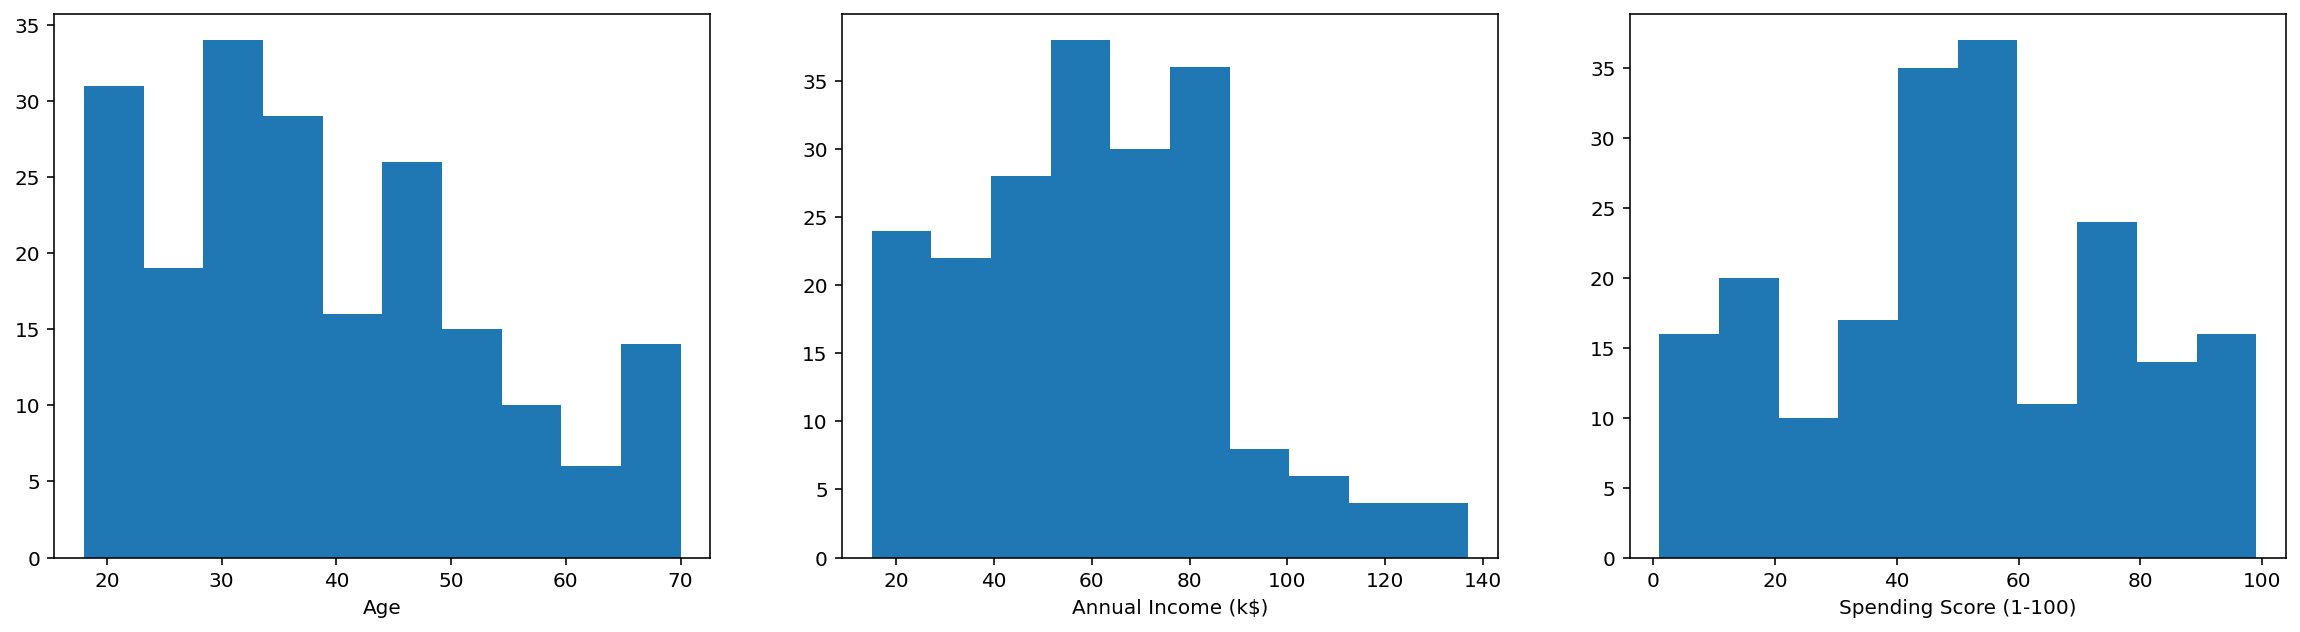

In [7]:
fig,ax=plt.subplots(1,3,figsize=(20,5))

listy = ['Age', 'Annual Income (k$)','Spending Score (1-100)']
for i in range(len(listy)):
    ax[i].hist(df[listy[i]])
    ax[i].set_xlabel(listy[i])

### Check the distribution of the non categorical columns between genders:

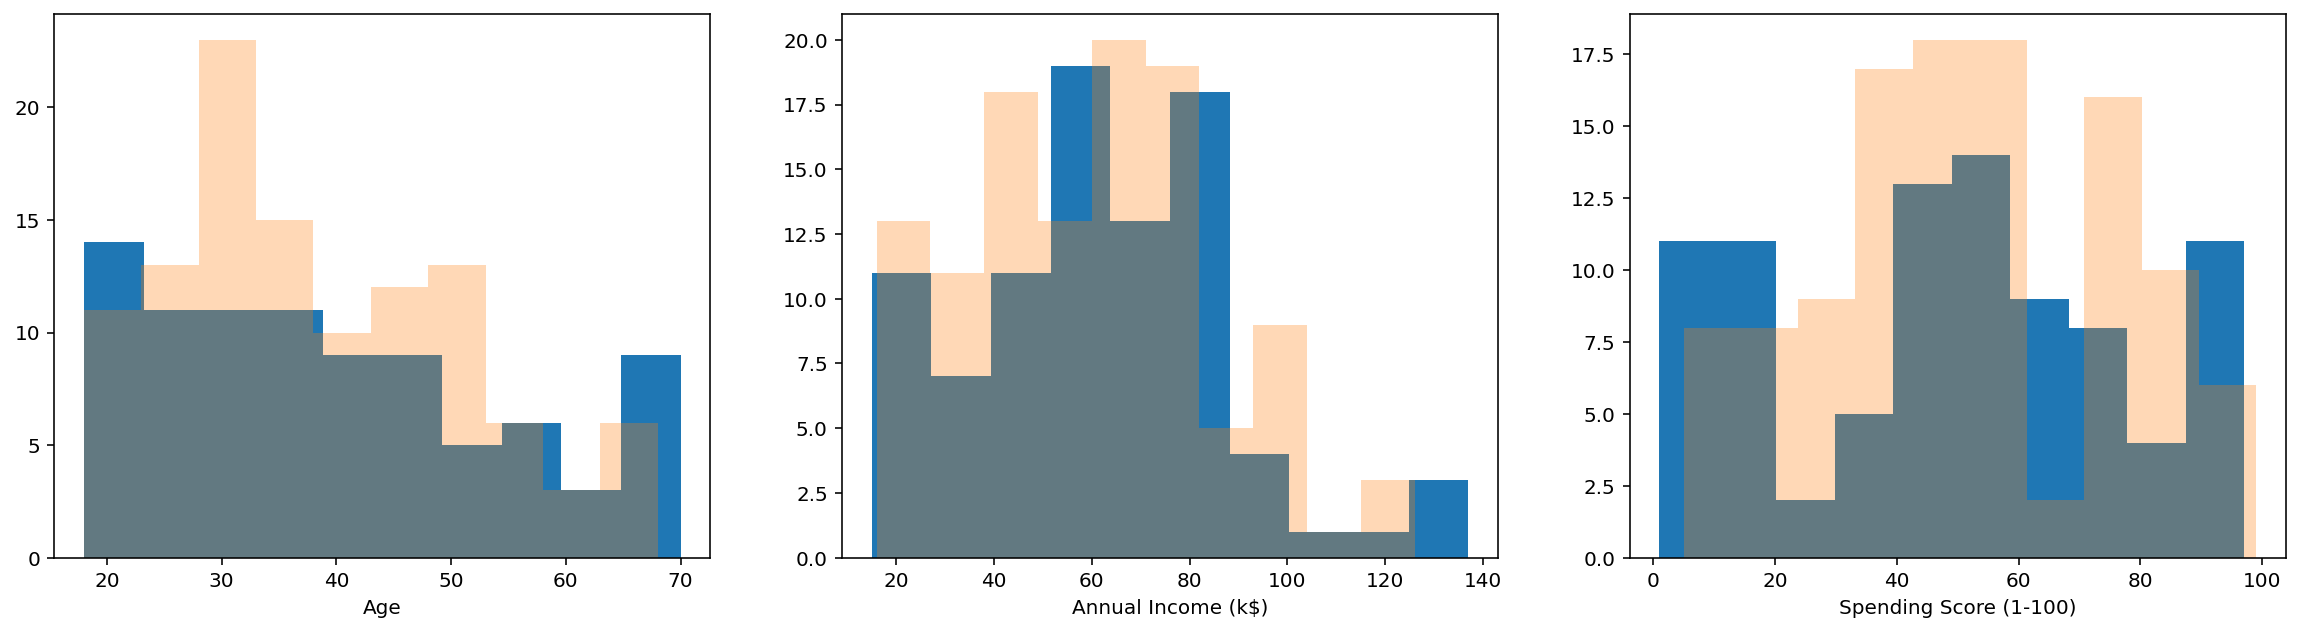

In [8]:
fig,ax=plt.subplots(1,3,figsize=(20,5))

listy = ['Age', 'Annual Income (k$)','Spending Score (1-100)']
for i in range(len(listy)):
    ax[i].hist(df[df['Gender'] == 'Male'][listy[i]])
    ax[i].set_xlabel(listy[i])
    ax[i].hist(df[df['Gender'] == 'Female'][listy[i]],alpha=0.3)
    ax[i].set_xlabel(listy[i])

### Let's plot a pairwise relationships meaning that each variable will by shared in the y-axis across a single row and in the x-axis across a single column:

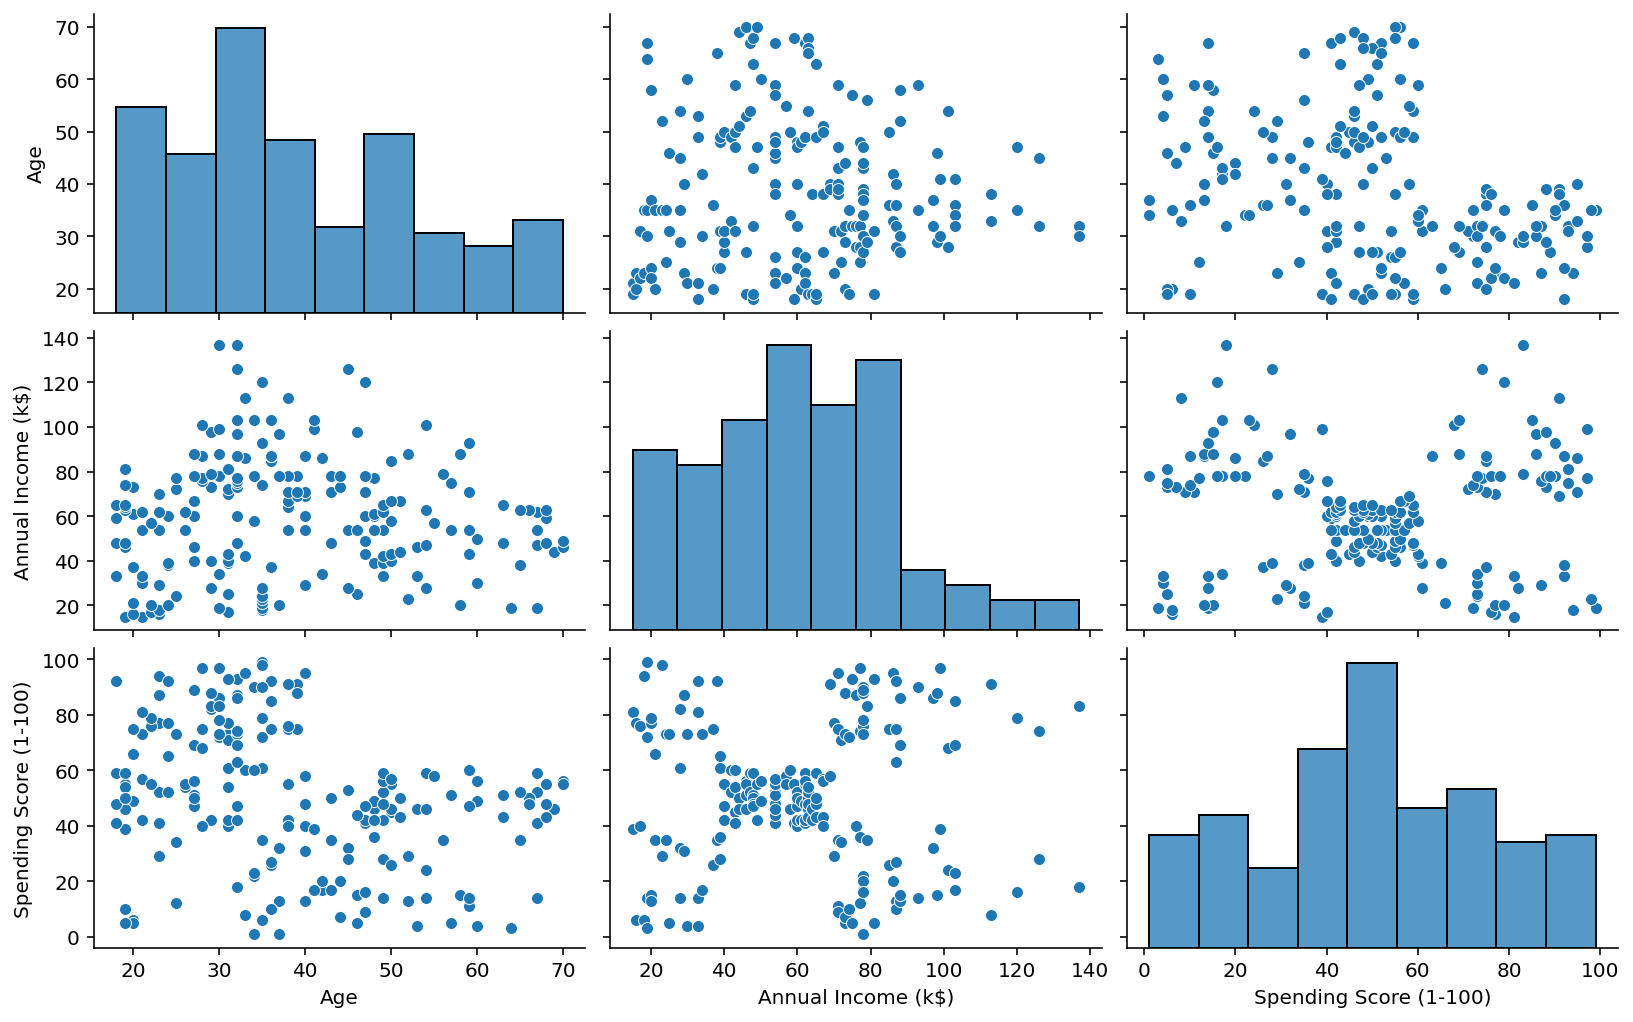

In [9]:
sns.pairplot(df, height=2.4, aspect=1.6);

### From the graphs above, 2 pairwise relationships are interesting:

    - The 'Age' versus 'Annual Income (k$)', you can slightly see 2 clusters forming:
            1. a younger population that spends a lot.
            2. an older population that spends less.
            
    - The 'Annual Income (k$)' versus 'Spending Score (1-100)', you can see clearly 5 clusters forming:
            1. Smaller income spending less.
            2. Smaller income spending more.
            3. Middle age, spending middle score.
            4. Bigger income spending less.
            5. Bigger income spending more.
            
Have a look below if it is unclear:

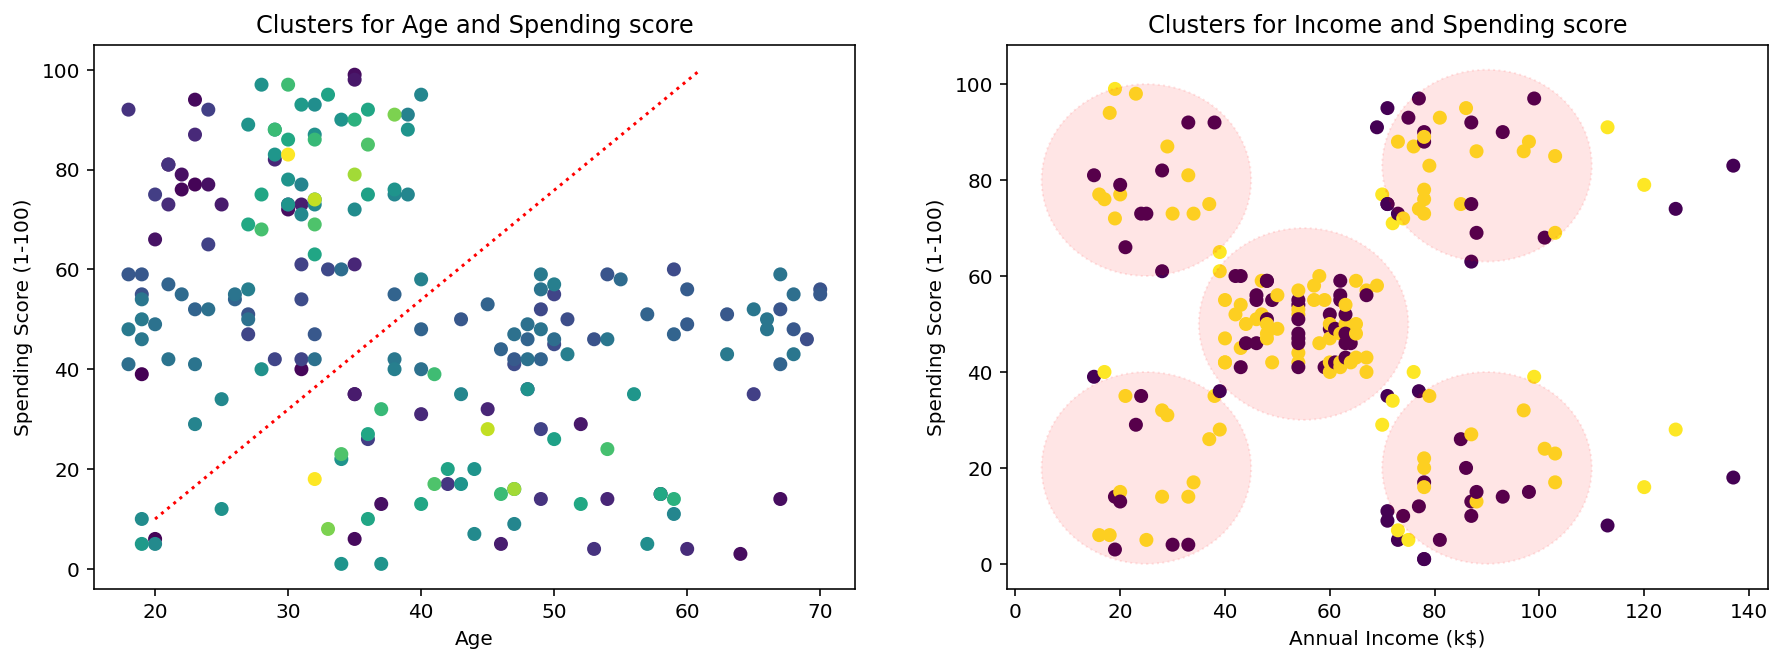

In [10]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

# fig = plt.gcf()
# ax[0] = fig.gca()

ax[0].scatter(df['Age'],df['Spending Score (1-100)'],c=df['Annual Income (k$)'])
ax[0].plot([20,61],[10,100], c='red',linestyle = 'dotted')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Spending Score (1-100)');
ax[0].set_title('Clusters for Age and Spending score');

circle1 = plt.Circle((25, 80), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle2 = plt.Circle((25, 20), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle3 = plt.Circle((55, 50), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle4 = plt.Circle((90, 20), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle5 = plt.Circle((90, 83), 20, alpha=0.1,color='red',linestyle = 'dotted')
ax[1].add_patch(circle1)
ax[1].add_patch(circle2)
ax[1].add_patch(circle3)
ax[1].add_patch(circle4)
ax[1].add_patch(circle5)

ax[1].scatter(df['Annual Income (k$)'],df['Spending Score (1-100)'],c=[0 if x=='Male' else 1 for x in df['Gender']])
ax[1].set_xlabel('Annual Income (k$)')
ax[1].set_ylabel('Spending Score (1-100)')
ax[1].set_title('Clusters for Income and Spending score');

### We will then focus on:

- 'Age' and 'Spending Score (1-100)', 
- 'Annual Income (k$)' and 'Spending Score (1-100)':

In [11]:
### Normalised our data:
for i in ['Age','Annual Income (k$)','Spending Score (1-100)']:
    df[i+'_norm'] = [(x-min(df[i]))/(max(df[i])-min(df[i])) for x in df[i]]
    
# ### Principal Component Analysis
# from sklearn.decomposition import PCA

# pca = PCA(2)
# pca.fit(df[[x for x in df.columns if '_norm' in x ]])
# pca_data = pd.DataFrame(pca.transform(df[[x for x in df.columns if '_norm' in x ]]))
# print(len(pca_data))
# pca_data.head(2)    

### Let's identify the ideal number of clusters based on our selection using Silhouette score:

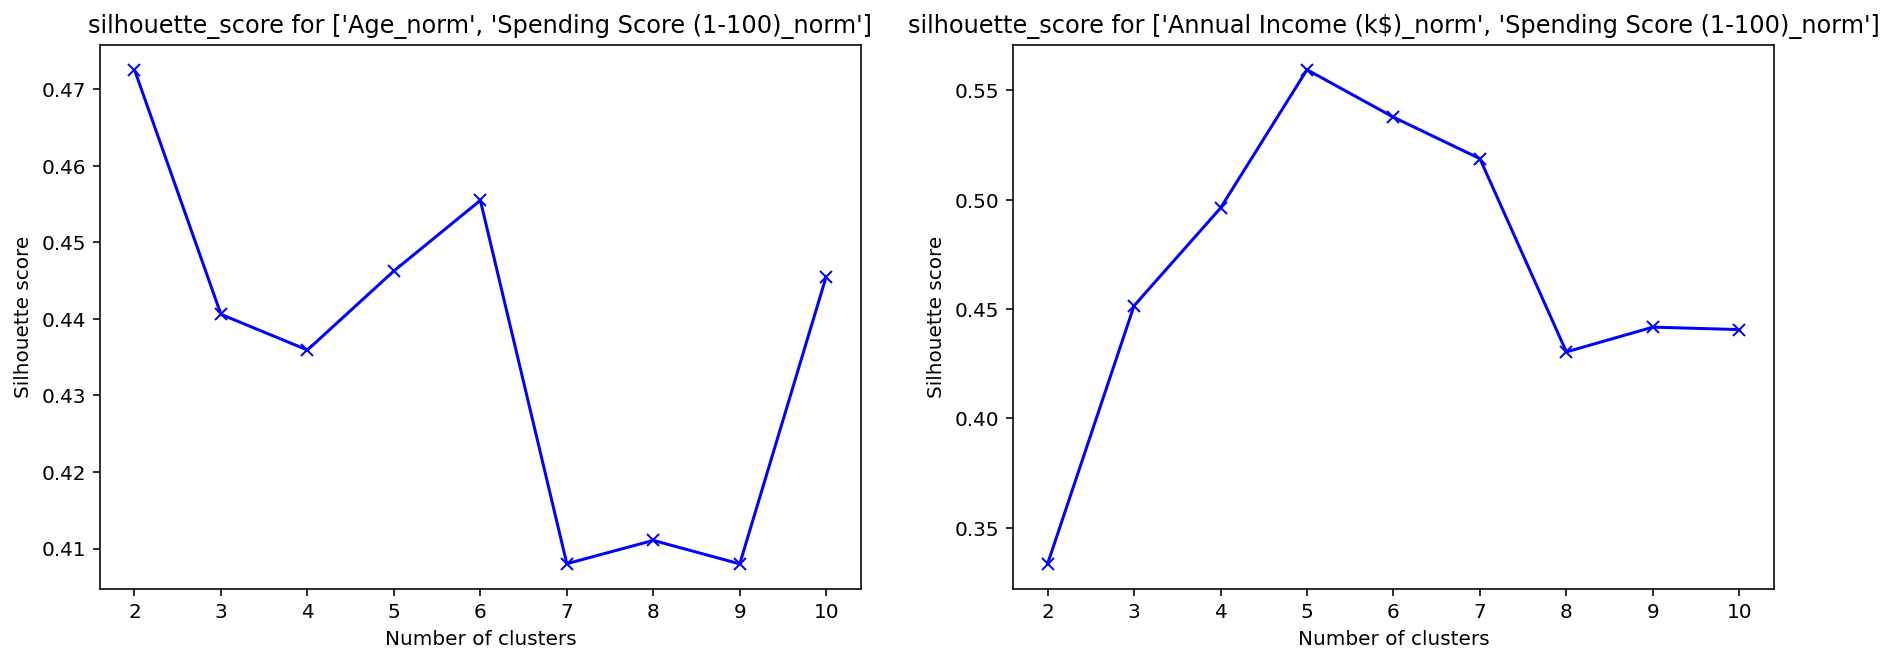

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

fig,ax = plt.subplots(1,2,figsize=(15,5))

list_cols = [['Age_norm','Spending Score (1-100)_norm'],['Annual Income (k$)_norm','Spending Score (1-100)_norm']]

ideal_clusters = []
for i in range(len(list_cols)):
    X = df[list_cols[i]]

    sil = []
    kmax = 10
    # dissimilarity would not be defined for a single cluster, 
    # meaning the minimum number of clusters is 2.
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(X)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric = 'euclidean'))
        
    ideal_clusters.append(max([x if y == max(sil) else 0 for x,y in zip(range(2,kmax+1), sil)]))
    
    ax[i].plot(range(2,kmax+1), sil, 'bx-');
    ax[i].set_xlabel('Number of clusters')
    ax[i].set_ylabel('Silhouette score')
    ax[i].set_title('silhouette_score for {}'.format(list_cols[i]))

### And here are our results:

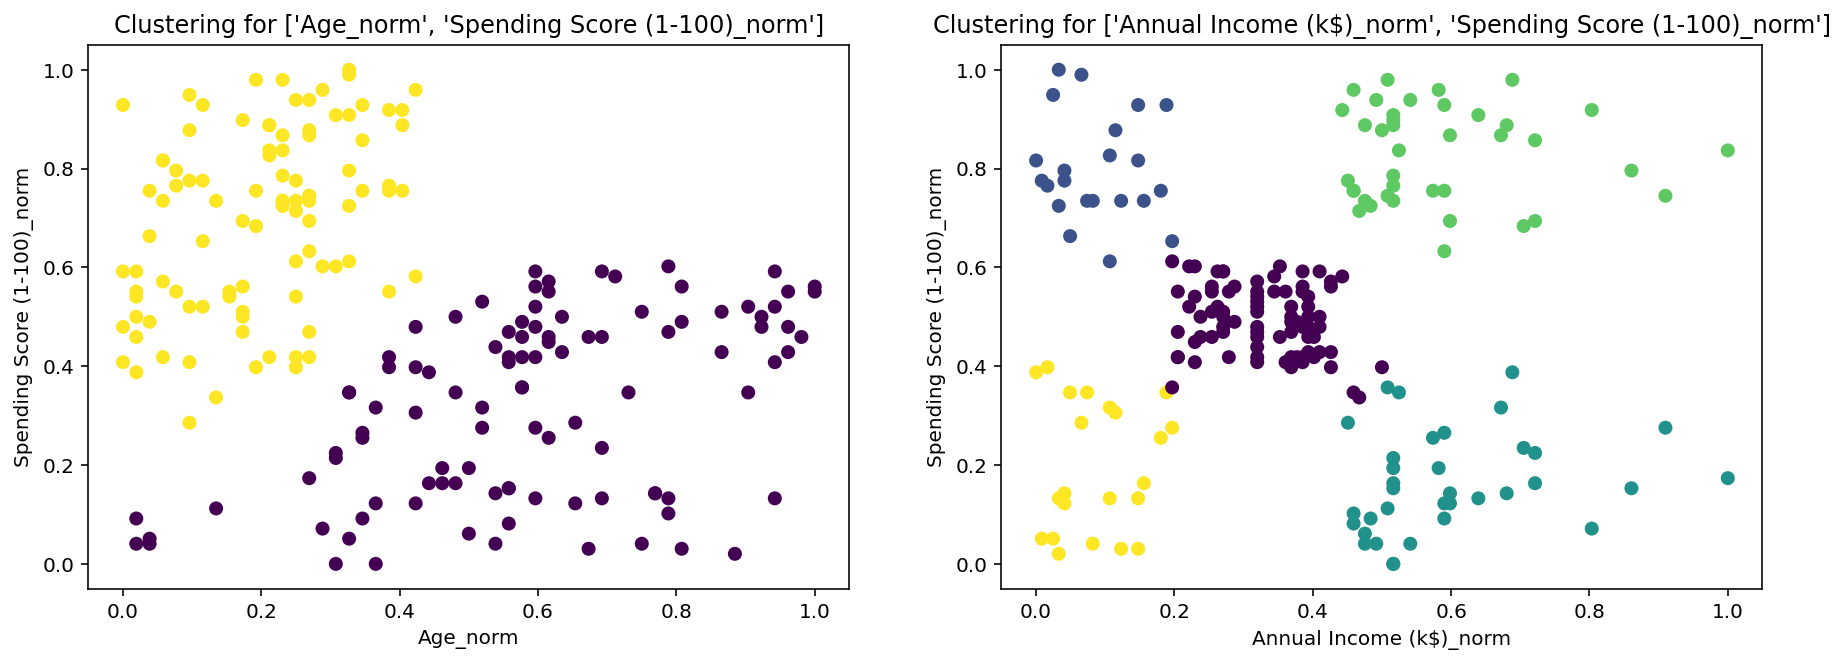

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(len(list_cols)):
    X = df[list_cols[i]]
    
    km = KMeans(n_clusters=ideal_clusters[i], random_state=1234).fit(X)
    df['pred_'+str(i)] = km.predict(X)
    
    ax[i].scatter(df[list_cols[i][0]],df[list_cols[i][1]],c=df['pred_'+str(i)]);
    ax[i].set_xlabel(list_cols[i][0])
    ax[i].set_ylabel(list_cols[i][1])
    ax[i].set_title('Clustering for {}'.format(list_cols[i]))

### We can clearly see that both approaches could be interesting for marketing strategies purposes.

For the map:

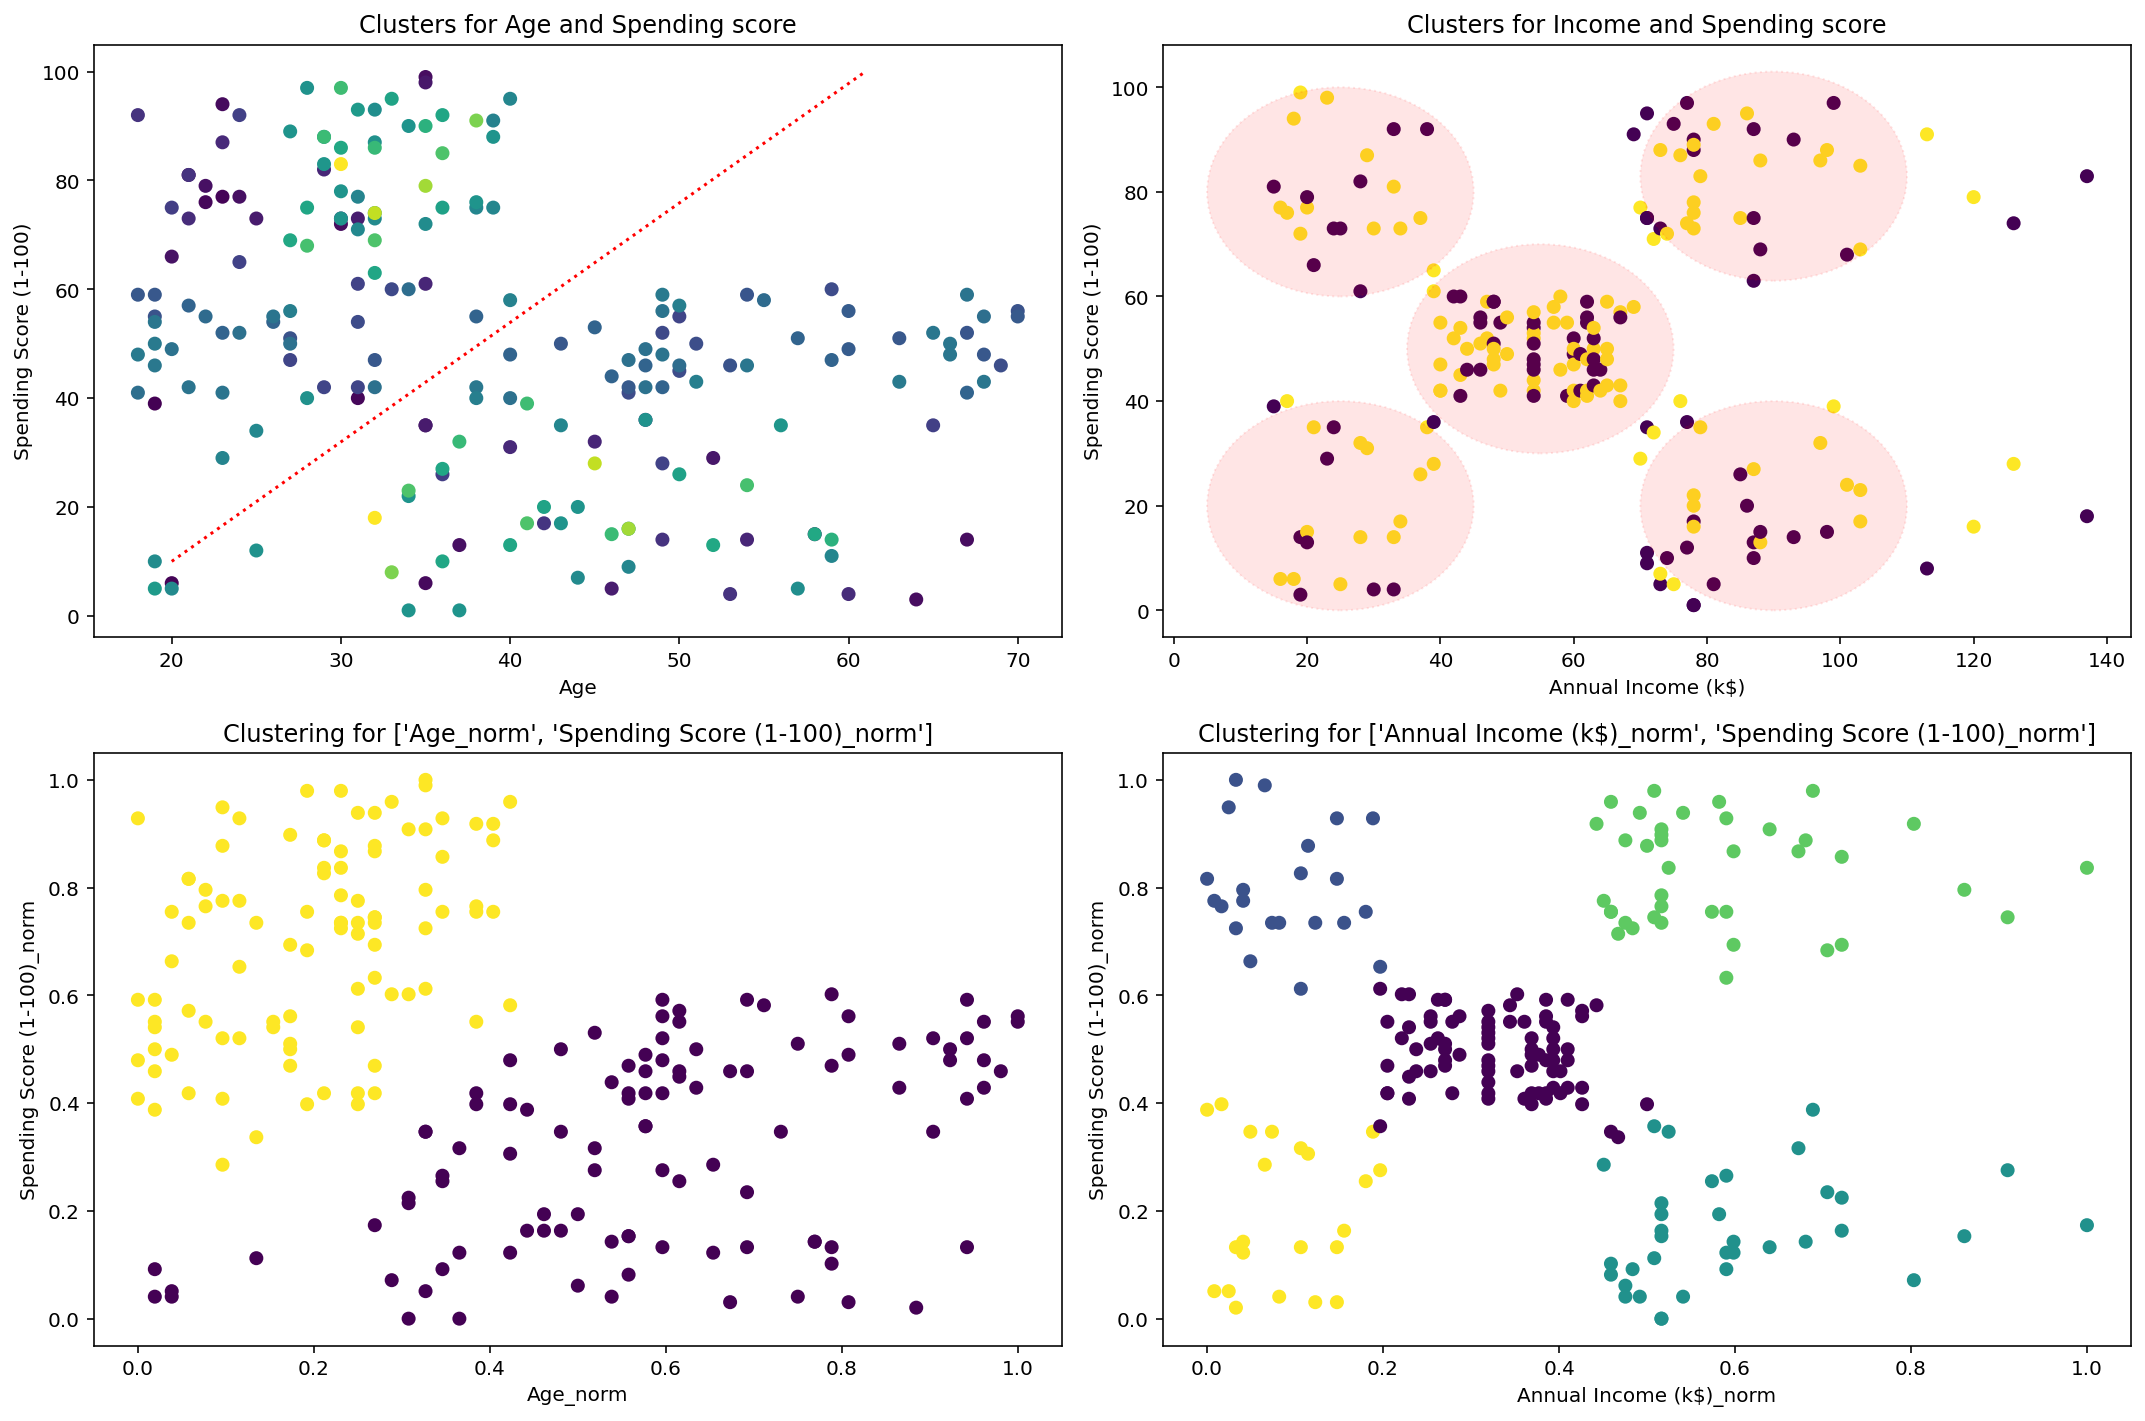

In [14]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

# axs[0,0]

ax[0,0].scatter(df['Age'],df['Spending Score (1-100)'],c=df['Annual Income (k$)'])
ax[0,0].plot([20,61],[10,100], c='red',linestyle = 'dotted')
ax[0,0].set_xlabel('Age')
ax[0,0].set_ylabel('Spending Score (1-100)');
ax[0,0].set_title('Clusters for Age and Spending score');

circle1 = plt.Circle((25, 80), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle2 = plt.Circle((25, 20), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle3 = plt.Circle((55, 50), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle4 = plt.Circle((90, 20), 20, alpha=0.1,color='red',linestyle = 'dotted')
circle5 = plt.Circle((90, 83), 20, alpha=0.1,color='red',linestyle = 'dotted')
ax[0,1].add_patch(circle1)
ax[0,1].add_patch(circle2)
ax[0,1].add_patch(circle3)
ax[0,1].add_patch(circle4)
ax[0,1].add_patch(circle5)

ax[0,1].scatter(df['Annual Income (k$)'],df['Spending Score (1-100)'],c=[0 if x=='Male' else 1 for x in df['Gender']])
ax[0,1].set_xlabel('Annual Income (k$)')
ax[0,1].set_ylabel('Spending Score (1-100)')
ax[0,1].set_title('Clusters for Income and Spending score');


X = df[list_cols[0]]
km = KMeans(n_clusters=ideal_clusters[0], random_state=1234).fit(X)
df['pred_'+str(0)] = km.predict(X)
    
ax[1,0].scatter(df[list_cols[0][0]],df[list_cols[0][1]],c=df['pred_'+str(0)]);
ax[1,0].set_xlabel(list_cols[0][0])
ax[1,0].set_ylabel(list_cols[0][1])
ax[1,0].set_title('Clustering for {}'.format(list_cols[0]))

X = df[list_cols[1]]
km = KMeans(n_clusters=ideal_clusters[1], random_state=1234).fit(X)
df['pred_'+str(1)] = km.predict(X)
    
ax[1,1].scatter(df[list_cols[1][0]],df[list_cols[1][1]],c=df['pred_'+str(1)]);
ax[1,1].set_xlabel(list_cols[1][0])
ax[1,1].set_ylabel(list_cols[1][1])
ax[1,1].set_title('Clustering for {}'.format(list_cols[1]))

plt.tight_layout()
plt.savefig('Mall Customers Analytics.png', dpi=500,transparent=False)
plt.show()